# Demo SingleRun
This notebook shows a single run consisting of the following four phases:
* sail empty
* loading
* sail full
* unloading

In [1]:
import datetime, time
import simpy

import shapely.geometry

import pandas as pd
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import openclsim.plugins as plugin
import numpy as np

init_notebook_mode(connected=True)

# setup environment
simulation_start  = datetime.datetime(2009,1,1)
my_env = simpy.Environment(initial_time=simulation_start.timestamp())
registry = {}
keep_resources = {}

In [2]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
    ),
    {},
)

TestMoveActivity =  type(
    "TestMoveActivity",
    (
        plugin.HasWeatherPluginActivity,
        model.MoveActivity,  # the order is critical!
    ),
    {},
)


TestShiftActivity =  type(
    "TestShiftActivity",
    (
        plugin.HasWeatherPluginActivity,
        model.ShiftAmountActivity,  # the order is critical!
    ),
    {},
)

In [3]:
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)  # lon, lat
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)  # lon, lat

data_from_site = {
    "env": my_env,
    "name": "Winlocatie",
    "geometry": location_from_site,
    "capacity": 120,
    "level": 120,
}


data_to_site = {
    "env": my_env,
    "name": "Dumplocatie",
    "geometry": location_to_site,
    "capacity": 120,
    "level": 0,
}

from_site = Site(**data_from_site)
to_site = Site(**data_to_site)

In [4]:
data_hopper = {
    "env": my_env,
    "name": "Hopper 01",
    "geometry": location_from_site,
    "capacity": 4,
    "compute_v":lambda x: 10,
}

hopper = TransportProcessingResource(**data_hopper)

In [5]:
metocean_df = pd.read_csv("../tests/data/unit_test_weather.csv")
metocean_df = metocean_df.set_index(pd.to_datetime(metocean_df["Time"], dayfirst=True))
metocean_df = metocean_df.sort_index()

metocean_df["Hs [m]"] = 4 + \
                        1.5*np.sin(metocean_df['  Hour']/24 * 8 *np.pi) + \
                        1.5*np.sin(metocean_df['  Hour']/24 * 6 *np.pi)

metocean_df = metocean_df.set_index(pd.to_datetime(metocean_df["Time"], dayfirst=True))
metocean_df = metocean_df.sort_index()
metocean_df["ts"] = metocean_df.index.values.astype(float) / 1_000_000_000

In [6]:
sailing_crit = plugin.WeatherCriterion(**{
    "name":"sailing_crit",
    "condition":"Hs [m]",
    "maximum":6,
    "window_length":3600
})

loading_crit = plugin.WeatherCriterion(**{
    "name":"loading_crit",
    "condition":"Hs [m]",
    "maximum":4.5,
    "window_length":3600
})

In [7]:
single_run = [
    TestMoveActivity(**{
        "env": my_env,
        "name": "Soil movement",
        "registry": registry,
        "mover": hopper,
        "destination": from_site,
        "metocean_criteria":sailing_crit,
        "metocean_df": metocean_df,
        "postpone_start": True,
    }),
    TestShiftActivity(**{
        "env": my_env,
        "name": "Transfer MP",
        "registry": registry,
        "processor": hopper,
        "origin": from_site,
        "destination": hopper,
        "amount": 4,
        "duration": 3600,
        "postpone_start": True,
        "metocean_criteria":loading_crit,
        "metocean_df": metocean_df,
    }),
    TestMoveActivity(**{
        "env": my_env,
        "name": "Soil movement",
        "registry": registry,
        "mover": hopper,
        "destination": to_site,
        "metocean_criteria":sailing_crit,
        "metocean_df": metocean_df,
        "postpone_start": True,
    }),
    TestShiftActivity(**{
        "env": my_env,
        "name": "Transfer TP",
        "registry": registry,
        "processor": hopper,
        "origin": hopper,
        "destination": to_site,
        "amount": 4,
        "duration": 3600,
        "postpone_start": True,
        "metocean_criteria":loading_crit,
        "metocean_df": metocean_df,
    })
]

activity = model.SequentialActivity(**{
    "env": my_env,
    "name": "Single run process",
    "ID": "6dbbbdf7-4589-11e9-bf3b-b469212bff60",
    "registry": registry,
    "sub_processes": single_run,
    "postpone_start": True,
})

expr = [{"type":"container", "concept": to_site, "state":"full"}]
while_data = {
    "env": my_env,
    "name": "while",
    "registry": registry,
    "sub_process": activity,
    "condition_event": expr,
    "postpone_start": False,
}
while_activity = model.WhileActivity(**while_data)


In [8]:
my_env.run()

In [11]:
plot.get_log_dataframe(while_activity, [while_activity, activity, *single_run])

,Timestamp,Activity,ActivityState
0,2009-01-01 00:00:00.000000,while,START
1,2009-01-01 00:00:00.000000,while,START
2,2009-01-01 00:00:00.000000,while,START
3,2009-01-01 00:00:00.000000,while,START
4,2010-01-01 03:00:00.000000,while,STOP
...,...,...,...
357,2010-01-05 23:31:25.649182,while,START
358,2010-01-06 00:31:25.649182,while,STOP
359,2010-01-06 00:31:25.649182,while,STOP
360,2010-01-06 00:31:25.649182,while,STOP


In [12]:
res = plot.vessel_planning([hopper], y_scale="numbers", static=True)
data = res['data']
layout = res['layout']

data.append({
    "name": "sailing_crit",
    "x":[hopper.log["Timestamp"][0].isoformat(), hopper.log["Timestamp"][-1].isoformat()],
    "y":[sailing_crit.maximum,sailing_crit.maximum],
})

data.append({
    "name": "Weather",
    "x":metocean_df.index,
    "y":metocean_df[sailing_crit.condition],
})



data.append({
    "name": "loading_crit",
    "x":[hopper.log["Timestamp"][0].isoformat(), hopper.log["Timestamp"][-1].isoformat()],
    "y":[loading_crit.maximum,loading_crit.maximum],
})

go.Figure(data=data, layout=layout)

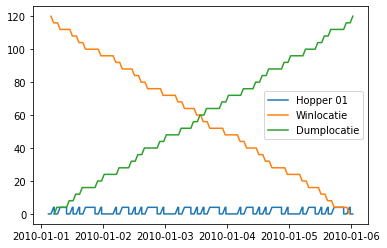

In [13]:
fig = plot.get_step_chart([hopper, from_site, to_site])